# Лабораторная работа №4
## ПМ-21М
## Егор Решетников
### Вариант 6
Лабораторная работа построена на фреймворках:

* [Keras](https://keras.io/guides) для построения нейронных сетей;
* [matplotlib](https://matplotlib.org/stable/tutorials/index.html) для работы с графиками;
* [numpy](https://numpy.org/doc/stable/) для работы с матрицами и векторами;
* [sklearn](https://scikit-learn.org/stable/user_guide.html) для тонкой настройки параметров с помощью кросс-валидации.

Для начала подключим необходимые библиотеки.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn import datasets, model_selection
from collections import namedtuple
import timeit

mpl.rcParams['axes.grid'] = True

class MyDataset:
    def __init__(self, *args):
        assert len(args) == 2 or len(args) == 4, 'x_train, x_test, y_train, y_test or (x_train, y_train), (x_test, y_test)'
        if len(args) == 2:
            (self.x_train, self.y_train), (self.x_test, self.y_test) = args
        else:
            self.x_train, self.x_test, self.y_train, self.y_test = args
    
    @property
    def train(self):
        return (self.x_train, self.y_train)
    
    @property
    def test(self):
        return (self.x_test, self.y_test)

if tuple(map(int, tf.__version__.split('.'))) < (2, 5, 0):
    tf.autograph.set_verbosity(0)
    import logging
    logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Часть №1. Разработка компонентов нейронной сети

Первая часть посвящена разработке слоёв нейронной сети.
Заранее будет определён класс `MyModel` для работы с моделью нейронной сети.
Целью этого класса является:

* Объединение всех слоёв в единую структуру.
* Организация обратного распространения ошибки.
* Отслеживание метрики штрафа и точности.
* Использование оптимизатора для уточнения весов сети (в данной работе будет использоваться градиентный спуск).
* Клонирование модели для поиска гипер параметров сети методом кросс-валидации.

In [2]:
class MyModel(keras.Model):
    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=0)

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def clone(self):
        clone_ = lambda x: x.from_config(x.get_config())
        
        model = keras.models.clone_model(self)
        model.set_weights(self.get_weights())
        metrics = [clone_(x) for x in self.compiled_metrics._metrics]
        model.compile(optimizer=clone_(self.optimizer), loss=clone_(self.loss), metrics=metrics)
        return model

### Задание №1.1. Линейный слой

Разработайте модель линейного слоя.
Перемножение матриц осуществляется с помощью функции `tf.matmul`.

In [3]:
import tensorflow as tf
from tensorflow import keras

class MyLayer(keras.layers.Layer):
    def __init__(self, units, seed, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.units_ = units
        self.seed_ = seed

    def build(self, input_shape):
        w_init = keras.initializers.RandomNormal(seed=self.seed_)
        self.w = self.add_weight(shape=(input_shape[-1], self.units_), initializer=w_init, trainable=True)
        self.b = self.add_weight(shape=(self.units_,), initializer=keras.initializers.Zeros(), trainable=True)

    @tf.function
    def call(self, inputs, training=False):
        return self.b + tf.matmul(inputs, self.w)

    def get_config(self):
        return {**super(MyLayer, self).get_config(), 'units': self.units_, 'seed': self.seed_}

# Тестирование

mylayer_test = MyLayer(20, seed=56)

assert mylayer_test(keras.Input(shape=(100,))).shape[1] == 20, 'Не поддержан метод build'
assert mylayer_test(tf.ones([3000, 100])).shape == (3000, 20), 'Не сохраняются веса после вызова метода build'

w = mylayer_test.get_weights()
assert len(w) == 2, 'Веса делятся на коэффициенты и смещения'
assert w[0].shape == (100, 20), 'Неправильное количество коэффициентов'
assert w[1].shape == (20,), 'Неправильное количество смещений'


### Задание №1.2. Градиентный спуск

В качестве оптимизатора градиентов будем использовать градиентный спуск.
Реализуйте его в следующем классе.
В качестве возращаемого значения используйте конструкцию `var.assign(...)`, в которую дожна помещаться формула градиентного спуска.

In [4]:
class GradDescent(keras.optimizers.legacy.Optimizer): # optimizers.legacy нужен для вызова _set_hyper
    def __init__(self, learning_rate=0.01, name="GradDescent", **kwargs):
        super(GradDescent, self).__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("learning_rate", learning_rate))
        self._set_hyper("decay", self._initial_decay)
    
    def _resource_apply_dense(self, grad, var, apply_state=None):
        lr = self._decayed_lr(var.dtype.base_dtype)
        return var.assign(var - lr * grad)
    
    def get_config(self):
        return {**super(GradDescent, self).get_config(), 'learning_rate': self._serialize_hyperparameter("learning_rate")}

### Задание №1.3. Подготовка датасета

Разрабатывать нейросеть будем на распространённом датасете `mnist`.
Загрузка обучающей и тестовой выборок осуществляется с помощью метода `load_data` из библиотеки `keras.datasets.mnist`.

In [5]:
d1 = MyDataset(*keras.datasets.mnist.load_data())

print(f"Размерности: x_train={d1.x_train.shape}:{d1.x_train.dtype}, y_train={d1.y_train.shape}:{d1.y_train.dtype}, x_test={d1.x_test.shape}, y_test={d1.y_test.shape}")

d1.x_train = d1.x_train.reshape(-1, np.prod(d1.x_train.shape[1:])) / 255.0
d1.x_test = d1.x_test.reshape(-1, np.prod(d1.x_test.shape[1:])) / 255.0

print(f"Размерности после преобразования: x_train={d1.x_train.shape}, y_train={set(d1.y_train)}")

Размерности: x_train=(60000, 28, 28):uint8, y_train=(60000,):uint8, x_test=(10000, 28, 28), y_test=(10000,)
Размерности после преобразования: x_train=(60000, 784), y_train={0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Впросы:

1. Каков размер обучающей выборки?
1. Какую оригинальную размерность имеет каждый обучающий вектор?
1. Каков размер тестовой выборки?
1. Какую размерность и значения имеет целевой вектор?

Ответы

1. 60000 значений
2. 28 на 28
3. 10000 значений
4. Целевой вектор имеет размерность 1. Он принимает значения от 0 до 9

### Задание №1.4. Определение архитектуры нейронной сети

Для определения архитектуры нейронной сети будем использовать объектный подход, который заключается в следующем.
Создаём абстрактные данные (входной слой) нужной размерности, но без уточнения количества векторов.
Рекурсивно вызываем все слои, входом которых будет выход с предыдущего слоя.
После этого создаём модель, входном которой являются абстрактные данные, созданные вначале, а выходом является выход самого последнего слоя.
Далее модель компилируется с помощью задания оптимизатора градиентного спуска (optimizer), функции потерь (loss) и функций метрик (metrics).
Полученную модель будем использовать как прототип, чтобы иметь возможность сбрасывать до первоначального состояния значения всех весов и гипер параметров нейронной сети.

In [6]:
inputs = keras.Input(shape=(d1.x_train.shape[-1],), name="digits")
x = MyLayer(len(set(d1.y_train)), seed=42, name="layer_1")(inputs)
outputs = keras.layers.Activation(keras.activations.softmax, name="softmax_1")(x)

mproto = MyModel(inputs=inputs, outputs=outputs)
mproto.compile(optimizer=GradDescent(0.1),
               loss=keras.losses.SparseCategoricalCrossentropy(),
               metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

mproto.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 layer_1 (MyLayer)           (None, 10)                7850      
                                                                 
 softmax_1 (Activation)      (None, 10)                0         
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Вопросы:

1. Какова размерность входных данных нейронной сети?
1. Сколько всего параметров у нейронной сети?
1. Сколько слоёв имеет нейронная сеть?

Ответы:

1. 784
2. 7850
3. 3

### Задание №1.5. Запуск полученной модели

Обучение нейронной сети осуществляется с помощью метода `fit`.
С помощью параметра `verbose` можно регулировать степень логирования процесса обучения.
В примере будем использовать параметр `validation_data`, который используется для запуска модели на переданных данных для получения метрик качества.
Параметр подразумевает, что будуте переданы валидационные данные, однако мы будем передавать туда наши тестовые векторы.
Мы можем так делать, потому что в данной модели валидационные данные **не влияют на обучение**.
Чтобы разобраться в отличии валидационных данных от тестовых, советуем ознакомиться с [этой дискуссией](https://github.com/keras-team/keras/issues/1753).

Постройте графики зависимости функции штрафа от количества эпох и точность классификации от количества эпох для обучающей и тестовой выборок.

Epoch 1/10

938/938 [==============================] - 10s 8ms/step - loss: 0.4829 - accuracy: 0.8722 - val_loss: 0.3375 - val_accuracy: 0.9073
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3382 - accuracy: 0.9057 - val_loss: 0.3079 - val_accuracy: 0.9155
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3152 - accuracy: 0.9118 - val_loss: 0.2975 - val_accuracy: 0.9165
Epoch 4/10
938/938 [==============================] - 5s 6ms/step - loss: 0.3032 - accuracy: 0.9152 - val_loss: 0.2902 - val_accuracy: 0.9204
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2953 - accuracy: 0.9171 - val_loss: 0.2846 - val_accuracy: 0.9190
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2896 - accuracy: 0.9188 - val_loss: 0.2818 - val_accuracy: 0.9206
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2852 - accuracy: 0.9201 - val_loss: 0.2815 - val_accuracy: 0.9222
Epoc

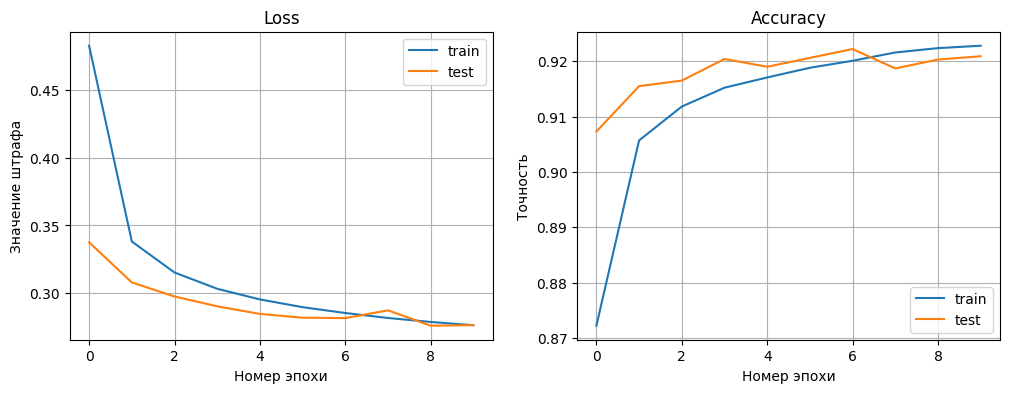

In [7]:
%%time
model = mproto.clone()
history = model.fit(*d1.train, batch_size=64, epochs=10, verbose=1, validation_data=d1.test)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
ax0.plot(history.history['loss'], label='train')
ax0.plot(history.history['val_loss'], label='test')
ax0.set(xlabel='Номер эпохи', ylabel='Значение штрафа', title='Loss')
ax0.legend()
ax1.plot(history.history['accuracy'], label='train')
ax1.plot(history.history['val_accuracy'], label='test')
ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
ax1.legend()

print(dict(zip(model.metrics_names, model.evaluate(*d1.test, verbose=0))))

Вопросы:

1. Сколько итераций было за эпоху?
1. Сколько использовалось векторов в одной итерации?
1. Какой точности удалось достичь?
1. Опишите поведение функции потерь и точности для обучающей и тестовой последовательностям. Насколько ни похожи?
1. Есть ли переобучение модели?

Ответы:

1. 938 (отображается в выводе скрипта)
2. 64 (передано в параметрах)
3. 0.92 (отображается в выводе скрипта
4. Функция потерь убывает с ростом эпохи, а точность - возрастает
5. В конце обоих графиков результаты ухудшаются на тестовой выборке, хотя улучшаются на тренировочной, что является признаком переобучения

Покажите, что получается на выходе нейронной сети, построив графики распределения ответов на последнем слое.
Также покажите на хит-мапе корреляцию ответов нейронной сети с реальными данными.

313/313 [==============================] - 1s 3ms/step


C:\Users\EReshetnikov\AppData\Local\Temp\ipykernel_23940\2736218099.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


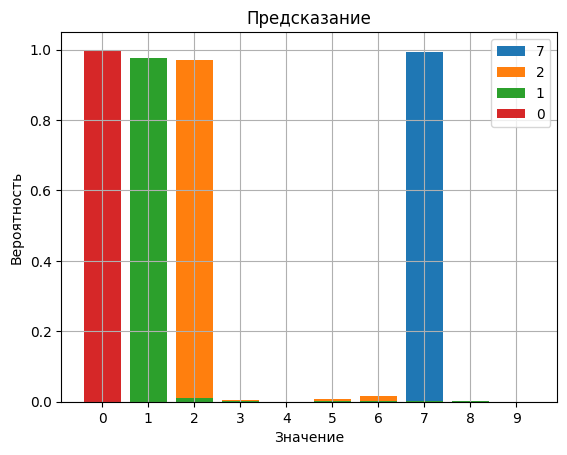

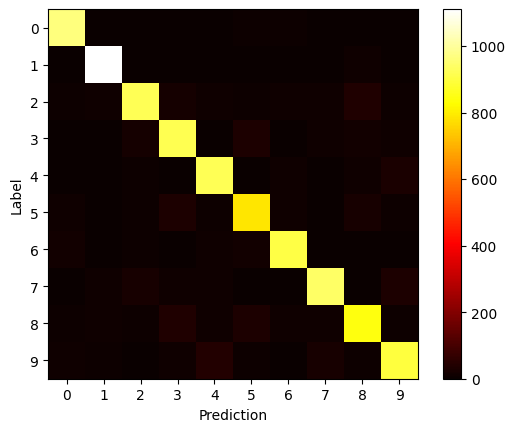

In [8]:
p = model.predict(d1.x_test)
for idx, pp in enumerate(p[:4]):
    plt.bar(np.arange(0, 10), pp, label=d1.y_test[idx])

plt.xlabel('Значение')
plt.ylabel('Вероятность')
plt.title('Предсказание')
plt.xticks(np.arange(0, 10))
plt.legend()

plt.figure()
plt.imshow(tf.math.confusion_matrix(d1.y_test, p.argmax(axis=1)), cmap='hot')
plt.colorbar()
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.xticks(list(set(d1.y_test)))
plt.yticks(list(set(d1.y_test)))
plt.grid(False)

Вопросы:

1. Что является выходом нейронной сети?
1. Какие значения принимает `y_train`?
1. Как нейронная сеть сравнивает свой выход с `y_train`?
1. Какая цифра распознаётся лучше всех, а какая хуже всех?

Ответы:

1. На выходе для каждого элемента исходной выборки мы получаем вектор распределения вероятности принадлежности этого элемента к какому-либо классу
2. Целые значения от 0 до 9
3. Порядковый номер наибольшего числа в выходном векторе вероятностей соответствует номеру класса
4. Лучше всех (ярче всего) по хит-мапу распознаётся 1, а хуже всех - 5

## Часть №2. Поиск оптимальных гиперпараметров нейронной сети

В этой части рассмотрим как происходит настройка гиперпараметров нейронной сети.
Гиперпараметр является лучшим, если при нём нейросеть показывает наилучшие характеристике на _тестовом_ датасете.
Тестирование во время обучения осуществляется с помощью механизма кросс-валидации.

### Задание №2.1. Загрузка датасета

Для демонстрации поиска параметров нейронной сети будем использовать искусственный датасет.
Получить его можно функцией `sklearn.datasets.make_classification`.
Параметры функции можно посмотреть в документации.
Нас пока будут интересовать параметры:

* `n_samples` - количество векторов обучения;
* `n_classes` - количество классов для классификации;
* `random_state` - для повторяемости генерации датасета;
* остальные параметры нужны для балансировки датасета.

x_train=(800, 2), y_train=(800,):{0, 1}, x_test=(200, 2)


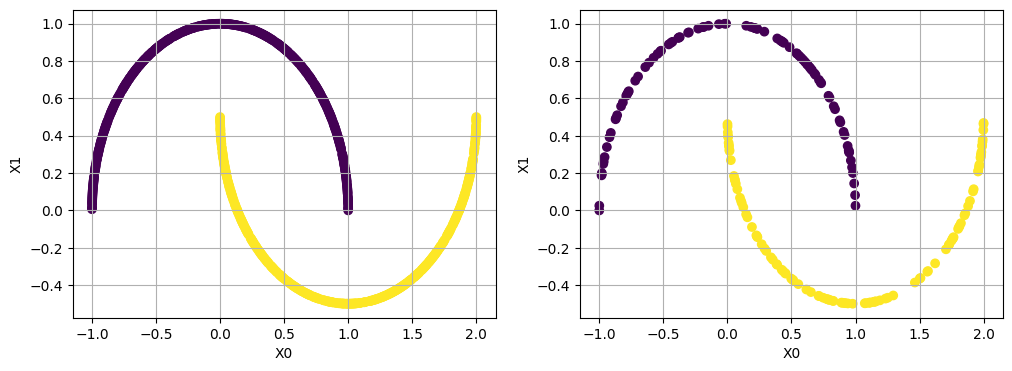

In [9]:
x, y = sk.datasets.make_moons(n_samples=1000, random_state=1)
d2 = MyDataset(*sk.model_selection.train_test_split(x, y, test_size=0.2))

print(f"x_train={d2.x_train.shape}, y_train={d2.y_train.shape}:{set(d2.y_train)}, x_test={d2.x_test.shape}")
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
for x, y, ax in [(d2.x_train, d2.y_train, ax0), (d2.x_test, d2.y_test, ax1)]:
    ax.scatter(x[:, 0], x[:, 1], c=y)
    ax.set(xlabel='X0', ylabel='X1')

### Задание №2.2. Поиск оптимальных параметров сети

Создание модели помещено в функцию, чтобы можно было "клонировать" нейронную сеть с изменёнными параметрами.
Параметр `batch_size` не входит в саму сеть, он будет подставляться уже при запуске обучения.

In [10]:
def create_model(units=50, activation='relu', lr=0.1):
    input_shape = (d2.x_train.shape[-1],)
    inputs = keras.Input(shape=input_shape)
    x = MyLayer(units, seed=49)(inputs)
    x = keras.layers.Activation(activation)(x)
    x = MyLayer(1, seed=75)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = MyModel(inputs, outputs)
    model.compile(GradDescent(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

params = {'lr': np.logspace(-2, 1.3, 7),
          'units': [2, 5, 10, 50, 100, 500, 1000],
          'batch_size': [1, 16, 64, 128, 1024],
          'activation': ['relu', 'tanh', 'softmax', 'sigmoid']
         }
print(params)

{'lr': array([1.00000000e-02, 3.54813389e-02, 1.25892541e-01, 4.46683592e-01,
       1.58489319e+00, 5.62341325e+00, 1.99526231e+01]), 'units': [2, 5, 10, 50, 100, 500, 1000], 'batch_size': [1, 16, 64, 128, 1024], 'activation': ['relu', 'tanh', 'softmax', 'sigmoid']}


### Задание №2.3. Исследование коэффициента скорости поиска

Переберите все параметры коэффициента скорости градиентного спуска `lr` и постройте графики:
* зависимость функции штрафа от номера эпохи,
* зависимость точности классификации от номера эпохи для обучающей и тестовой выборок.


CPU times: total: 13min 23s
Wall time: 10min 55s


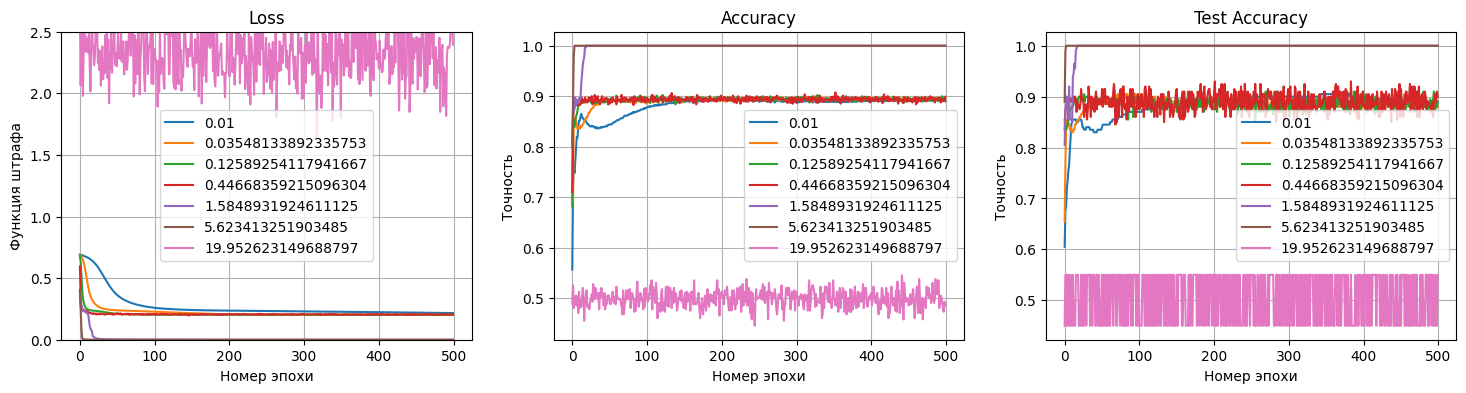

In [11]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*6, 4))
for p in params['lr']:
    model = create_model(lr=p)
    history = model.fit(*d2.train, validation_data=d2.test, epochs=500, verbose=0)
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()

Вопросы:

1. Что было бы, если бы в примере было гораздо больше эпох (можно поэкспериментировать с количеством эпох)?
1. При всех ли коэффициентах `lr` достигается 100% точность (нулевая функция потерь)?
1. Сформулируйте правило: чем больше значение `lr`, тем скорость обучения выше/ниже?

Ответы:

1. Результат сильно не изменился бы, так как значения весов уже сошлись
2. Нет, так как при большем $lr$ мы можем "перепрыгивать" оптмильные значения 
3. Чем $lr$ больше, тем скорость обучения выше до тех пор, пока $lr$ не станет слишком большим из-за чего мы не подберемся к оптимальным значениям

### Задание №2.4. Исследование размера скрытого слоя

Размером скрытого слоя будем называть количество содержащихся в нём нейронов.
Изучим, как количество нейронов в скрытом слое влияет на точность и скорость обучения.
Постройте графики зависимостей:

* функции потерь от номера эпохи;
* точность классификации от номера эпохи для обучающей и тестовой выборок;
* время обучения модели от количества нейронов.

CPU times: total: 1min 40s
Wall time: 1min 17s


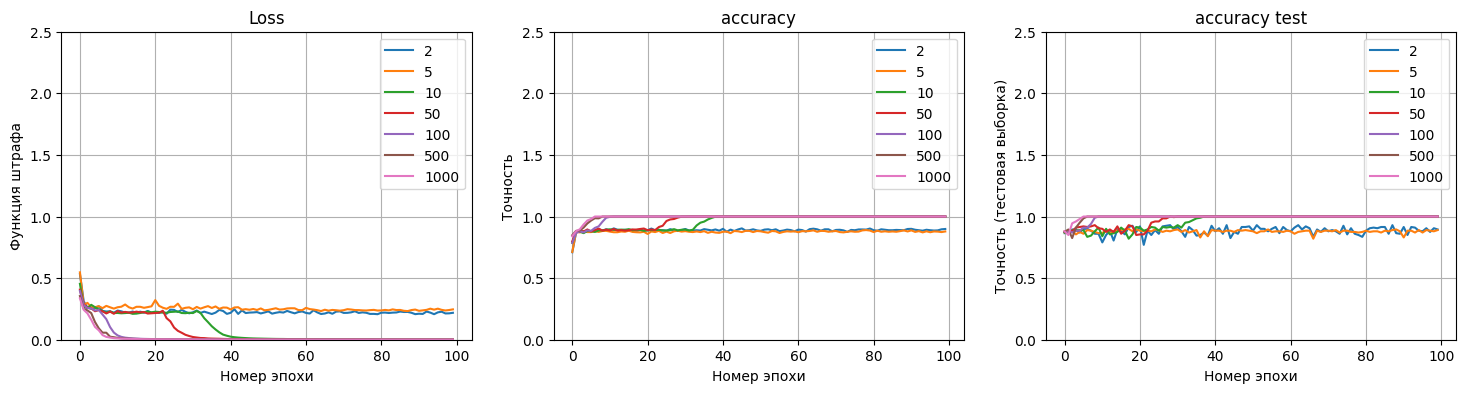

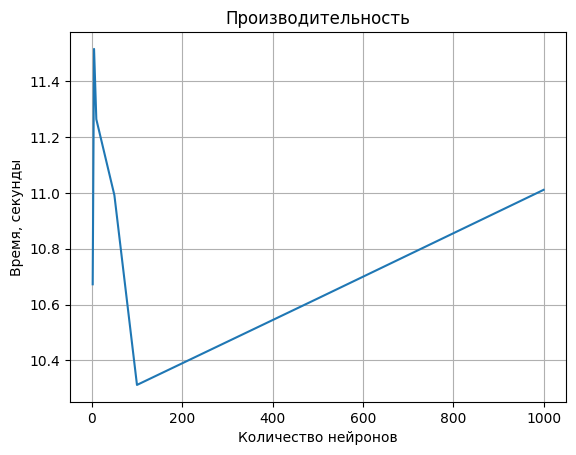

In [14]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*6, 4))
layer_timer = {}
for p in params['units']:
    model = create_model(units=p, lr=1.5)
    t = timeit.default_timer()
    history = model.fit(*d2.train, validation_data=d2.test, epochs=100, verbose=0)
    layer_timer[p] = timeit.default_timer() - t
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='accuracy', ylim=[0, 2.5])
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность (тестовая выборка)', title='accuracy test', ylim=[0, 2.5])
    ax2.legend()
    

plt.figure()
plt.xlabel('Количество нейронов')
plt.ylabel('Время, секунды')
plt.title('Производительность')
plt.plot(layer_timer.keys(), layer_timer.values()) # python3.7+

Вопросы:

1. Как связаны скорость обучения и размер скрытого слоя?
1. Как связаны время обучения (секунды, потраченные на обучение) и размер скрытого слоя?
1. Что наблюдается при очень малом количестве нейронов в скрытом слое?
1. Что наблюдается при очень большом количестве нейронов в скрытом слое?

Ответы:

1. С ростом количества нейронов скорость обучения увеличивается
2. После определенного порога скорость начинает убывать с ростом количества нейронов
3. Нейронов слишком мало, чтобы уловить закономерности в данных, размерности не хватает, из-за этого появляется потолок по точности
4. В данном случае переобучение не наблюдается, так как ошибка на тестовой выборке и тренировочной не расходится

### Задание №2.5. Исследование размера батча

Размер батча определяется в методе `fit` настроенной модели параметром `batch_size`.
Постройте графики зависимостей:

* функции потерь от номера эпохи;
* точность классификации от номера эпохи для обучающей и тестовой выборок;
* время обучения модели от количества нейронов.

CPU times: total: 5min 12s
Wall time: 3min 45s


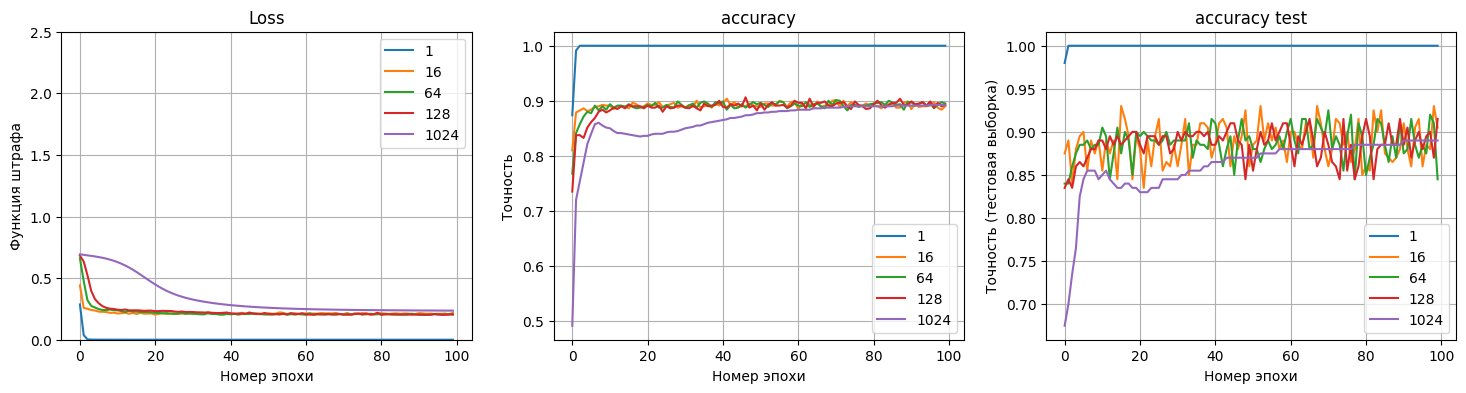

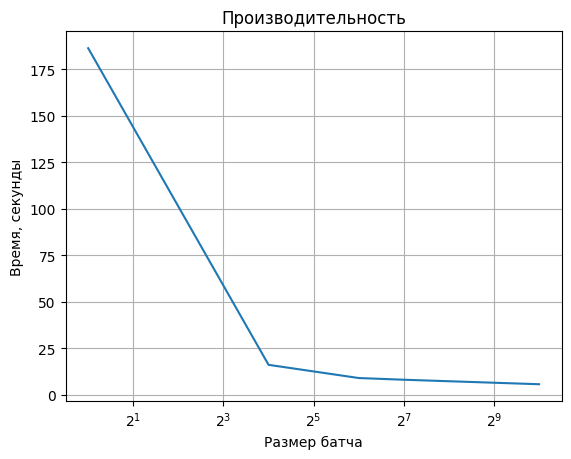

In [20]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*6, 4))
batch_timer = {}
for p in params['batch_size']:
    model = create_model(units=50, lr=0.5)
    t = timeit.default_timer()
    history = model.fit(*d2.train, validation_data=d2.test, epochs=100, batch_size=p, verbose=0)
    batch_timer[p] = timeit.default_timer() - t
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность (тестовая выборка)', title='accuracy test')
    ax2.legend()

plt.figure()
plt.xlabel('Размер батча')
plt.ylabel('Время, секунды')
plt.title('Производительность')
plt.semilogx(batch_timer.keys(), batch_timer.values(), base=2) # python3.7+

Вопросы:

1. При всех ли значениях размера батча достигается 100% точность на тестовой/обучающей выборках?
1. Что будет, если понизить коэффициент скорости градиентого спуска `lr`? Добейтесь, чтобы все графики выглядели "хорошо".
1. Запишите правило: чем больше размер батча, тем скорость обучения выше/ниже?
1. Что наблюдается со временем обучения (секунды, потреченные на обучение) при повышении размера батча?

Ответы:

1. Нет, при минимальном размере батча точность $100%$ не достигается
2. Точность для небольших батчей заметно улучшается. Минимальный батч дает $100%$ точность
3. Чем больше размер батча, тем скорость обучения ниже
4. С повышение размера батча время обучения сокращается, т.к. в этом случае количество расчетов сокращается

### Задание №2.6. Исследование функций активации скрытого слоя

Переберите функции активаций.
Постройте графики зависимостей:

* функции потерь от номера эпохи;
* точность классификации от номера эпохи для обучающей и тестовой выборок;
* время обучения модели от количества нейронов.

CPU times: total: 1min 28s
Wall time: 1min 5s


<BarContainer object of 4 artists>

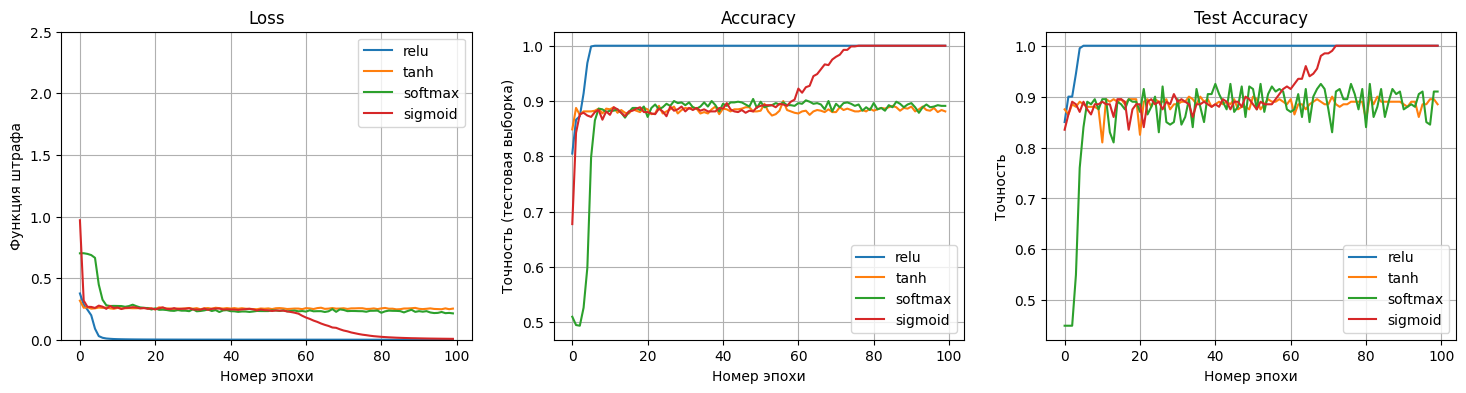

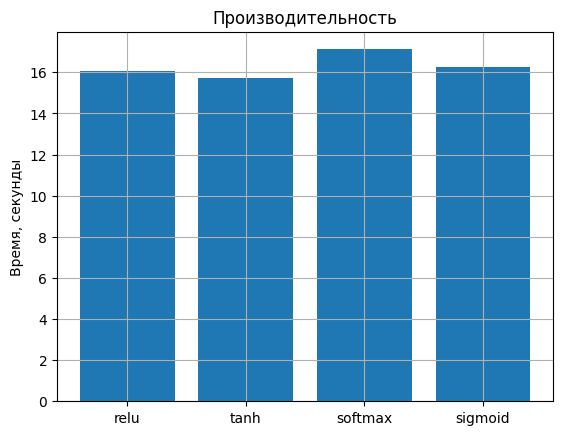

In [16]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(3*6, 4))
activation_timer = {}
for p in params['activation']:
    model = create_model(units=50, lr=1.5, activation=p)
    t = timeit.default_timer()
    history = model.fit(*d2.train, validation_data=d2.test, batch_size=16, epochs=100, verbose=0)
    activation_timer[p] = timeit.default_timer() - t
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss', ylim=[0, 2.5])
    ax0.legend()
    ax1.plot(history.history['accuracy'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Точность (тестовая выборка)', title='Accuracy')
    ax1.legend()
    ax2.plot(history.history['val_accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax2.legend()
    
plt.figure()
plt.ylabel('Время, секунды')
plt.title('Производительность')
plt.bar(activation_timer.keys(), activation_timer.values()) # python3.7+

Вопросы:

1. При какой(их) функции активации скрытого слоя достигается максимальная точность?
1. При какой(их) функции активации скрытого слоя максимальная точности достигается быстрее всего?
1. Как влияет функция активации на время обучения (секунды, потреченные на обучение)?

Ответы:

1. С использованием relu и sigmoid
2. relu
3. В целом разница незначительна, но наибольший отрыв показывает softmax

## Часть №3. Применение Dropout

Применение dropout для решения проблем переобучения.

### Задание №3.1. Составление датасета

Подготовим датасет, который отвечает следующим критериями.

(210, 4) float64 (210,) int32 (90, 4)


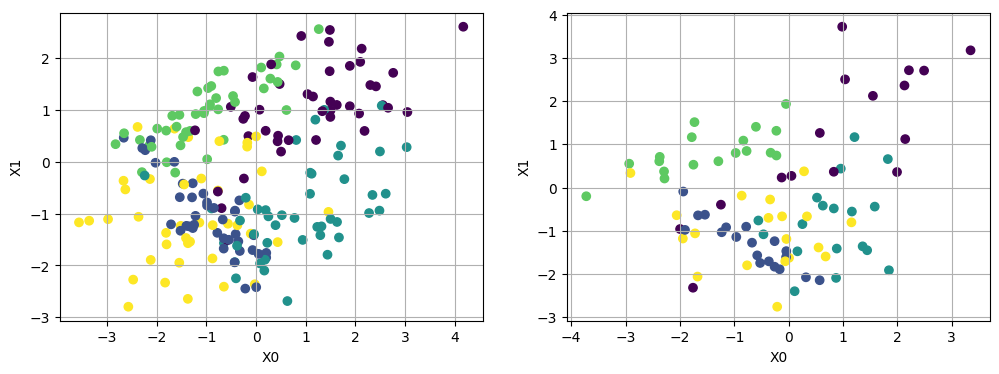

In [17]:
x, y = sk.datasets.make_classification(n_samples=300, n_classes=5, n_features=4, n_informative=3, n_redundant=0, n_clusters_per_class=1, random_state=1)
d3 = MyDataset(*sk.model_selection.train_test_split(x, y, test_size=0.3))

print(d3.x_train.shape, d3.x_train.dtype, d3.y_train.shape, d3.y_train.dtype, d3.x_test.shape)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*6, 4))
for x, y, ax in [(*d3.train, ax0), (*d3.test, ax1)]:
    ax.scatter(x[:, 0], x[:, 1], c=y)
    ax.set(xlabel='X0', ylabel='X1')

### Задание №3.2. Составление модели

В нейросетевой модели сделаем один скрытый слой с большим количеством нейронов.
Постройте графики зависимостей:

* функции потерь от номера эпохи для обучающей и тестовой выборок;
* точность классификации от номера эпохи для обучающей и тестовой выборок.

Model: "my_model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 4)]               0         
                                                                 
 linear_1 (MyLayer)          (None, 100)               500       
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 linear_end (MyLayer)        (None, 5)                 505       
                                                                 
 activation_end (Activation  (None, 5)                 0         
 )                                                               
                                                                 
Total params: 1005 (3.93 KB)
Trainable params: 1005 (3.93 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

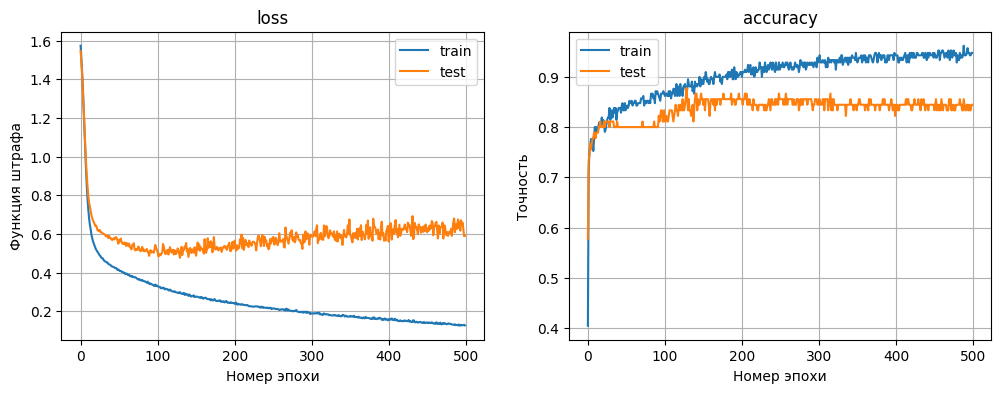

In [18]:
%%time
def create_model3():
    inputs = keras.layers.Input(shape=(d3.x_train.shape[-1],), name="inputs")
    x = MyLayer(100, seed=12, name='linear_1')(inputs)
    x = keras.layers.Activation('relu', name='activation_1')(x)
    x = MyLayer(len(set(d3.y_train)), seed=47, name='linear_end')(x)
    outputs = keras.layers.Activation('softmax', name='activation_end')(x)
    model = MyModel(inputs=inputs, outputs=outputs)
    model.compile(optimizer=GradDescent(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model3 = create_model3()
model3.summary()
history3 = model3.fit(*d3.train, epochs=500, validation_data=d3.test, verbose=0)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6*2, 4))
ax0.plot(history3.history['loss'], label='train')
ax0.plot(history3.history['val_loss'], label='test')
ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='loss')
ax0.legend()
ax1.plot(history3.history['accuracy'], label='train')
ax1.plot(history3.history['val_accuracy'], label='test')
ax1.set(xlabel='Номер эпохи', ylabel='Точность', title='accuracy')
ax1.legend()

result = model3.evaluate(*d3.test, verbose=0)
print(dict(zip(model3.metrics_names, result)))

Вопросы:

1. Насколько сильно отличается точность на обучающей и тестовой выборках?
1. Наблюдается ли переобучение?

Ответы:

1. Судя по графику, примерно на $0.1$
1. Да, так как графики функции штрафа на тестовой и тренировочной выборке расходятся

### Задание №3.3. Разработка слоя Dropout

Реализуйте слой Dropout.
Так как этот слой применяется только при обучении модели, необходимо анализировать параметр `training`, чтобы отлючать функциональность слоя при обычном запуске модели.
Все вычисления в Tensorflow проводятся в отложенном режиме.
Это означает, что результат вычислений будет известен не в точке написания формулы, а где-нибудь в другом месте.

При разработке слоя используйте функции:

* `tf.random.uniform` - возвращает вектор случайных чисел из заданного интервала (обязательно передайте параметр `shape` и `seed`);
* возможно потребуется функция `tf.cast`, чтобы поменять тип некоторых операндов;
* примитивные операции (умножение, сложение и т.д.) можно делать так, как есть;
* над операндами можно проводить операции сравнения;
* используйте [tf.shape](https://www.tensorflow.org/api_docs/python/tf/shape), чтобы отложенно проводить вычисление для неопределённой размерности тензора (например, `[None, 10]`).

In [21]:
class MyDropout(keras.layers.Layer):
    def __init__(self, rate, seed, **kwargs):
        kwargs['trainable'] = False
        super(MyDropout, self).__init__(**kwargs)
        self.rate_ = rate
        self.scale_ = 1 / (1 - rate)
        self.seed_ = seed

    @tf.function
    def call(self, inputs, training=False):
        if training:
            trasformed = tf.random.uniform(shape=tf.shape(inputs), minval=0, maxval=1, seed=self.seed_)
            return inputs * tf.cast(trasformed > self.rate_, tf.float32) * self.scale_
        else:
            return inputs
    
    def get_config(self):
        return {**super(MyDropout, self).get_config(), 'rate': self.rate_, 'seed': self.seed_}

# Тестирование

drop_test = MyDropout(0.25, 49)
t = drop_test(tf.ones([300, 10]), training=True)

assert 0.2 < len(t[t == 0]) / 3000 < 0.3, 'Вероятность dropout вне исследуемого диапазона'
assert tf.math.reduce_all(t[t != 0] == 4/3), 'Масштабирование переменных не корректно'
try:
    drop_test(keras.Input(shape=(10,)), training=True)
except:
    assert False, 'Не поддерживается частичная форма тензора'

### Задание №3.4. Составление модели с Dropout

В модель добавить слой `MyDropout`.
Необходимо выяснить закономерность параметра `rate`.
Постройте графики зависимости функции потерь и точности классификации для обучающей и тестовой выборок.
Графики сгруппируйте так: отдельно обучающая выборка, отдельно тестовая.

rate 0 {'loss': 0.6841995120048523, 'accuracy': 0.7888888716697693}
rate 0.01 {'loss': 0.684119701385498, 'accuracy': 0.800000011920929}
rate 0.02 {'loss': 0.6934545636177063, 'accuracy': 0.7888888716697693}
rate 0.05 {'loss': 0.7238237261772156, 'accuracy': 0.7888888716697693}
rate 0.1 {'loss': 0.8029024600982666, 'accuracy': 0.7888888716697693}
rate 0.25 {'loss': 1.0246829986572266, 'accuracy': 0.7888888716697693}
rate 0.6 {'loss': 1.9654344320297241, 'accuracy': 0.7888888716697693}
rate 0.9 {'loss': 3.6767048835754395, 'accuracy': 0.7444444298744202}
CPU times: total: 5min 27s
Wall time: 4min 17s


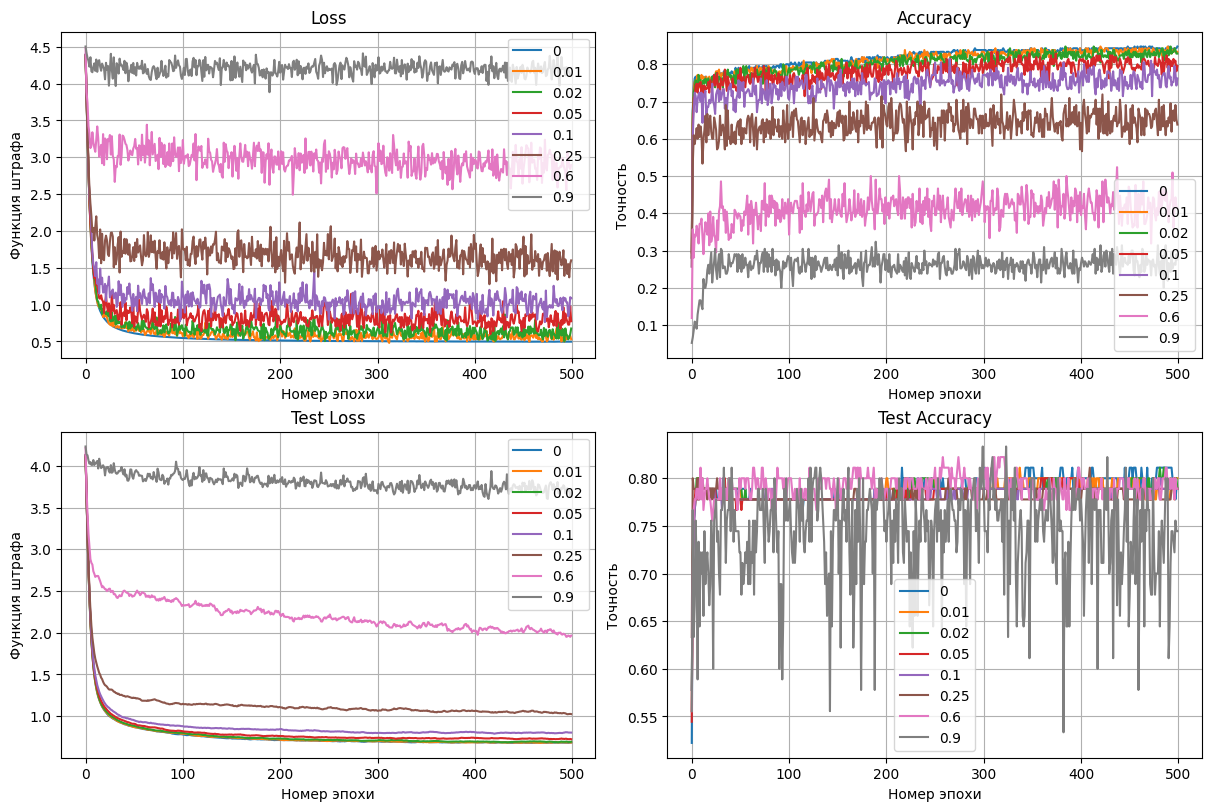

In [27]:
%%time
def create_model32(rate):
    inputs = keras.layers.Input(shape=(d3.x_train.shape[-1],), name="inputs")
    x = MyLayer(100, seed=42)(inputs)
    x = MyDropout(rate, seed=42)(x)
    outputs = keras.layers.Activation('softmax', name='activation_end')(x)
    model = MyModel(inputs=inputs, outputs=outputs)
    model.compile(optimizer=GradDescent(0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(2, 2, figsize=(2*6, 2*4), constrained_layout=True)
for p in [0, 0.01, 0.02, 0.05, 0.1, 0.25, 0.6, 0.9]:
    model = create_model32(rate=p)
    history = model.fit(*d3.train, validation_data=d3.test, epochs=500, verbose=0)
    print('rate', p, dict(zip(model.metrics_names, model.evaluate(*d3.test, verbose=0))))
    ax0.plot(history.history['loss'], label=p)
    ax0.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Loss')
    ax0.legend()
    ax1.plot(history.history['val_loss'], label=p)
    ax1.set(xlabel='Номер эпохи', ylabel='Функция штрафа', title='Test Loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label=p)
    ax2.set(xlabel='Номер эпохи', ylabel='Точность', title='Accuracy')
    ax2.legend()
    ax3.plot(history.history['val_accuracy'], label=p)
    ax3.set(xlabel='Номер эпохи', ylabel='Точность', title='Test Accuracy')
    ax3.legend()

**Вопросы:**

1. Как меняется точность классификации на обучающей выборке при повышении значения параметра `rate`?
1. Как меняется точность классификации на тестовой выборке при повышении значения параметра `rate`?
1. Введение Dropout как-то решает проблему с переобучением?
1. Удалось ли повысить точность классификации с помощью введения слоя Dropout? Поэкспериментируйте и получите параметр `rate`, при котором получается наибольшая точность классификации.

**Ответы:**

1. Точность снижается
2. Для значения $0.9$ повышается СКО точности, в остальных случаях результат не сильно отличается в зависимости от `rate`
3. Да
4.  